In [47]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("talk")
sns.set_style("whitegrid")

ID = "22972495"
RESULTS_DIR = f"/mnt/nas_siddharth/code_final/results3D/example/{ID}"

def try_load_pickle(path):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"[WARN] Could not load {path}: {e}")
        return None

kp3d  = try_load_pickle("/mnt/nas_siddharth/code_final/results3D/example/kp3d.pickle")
kp2d  = try_load_pickle("/mnt/nas_siddharth/code_final/results3D/example/kp2d.pickle")
cid   = try_load_pickle("/mnt/nas_siddharth/code_final/results3D/example/collar_id.pickle")
track = try_load_pickle("/mnt/nas_siddharth/code_final/results3D/example/track.pickle")

frame_nums = np.load(os.path.join(RESULTS_DIR, "frame_num.npy"))

# Extract number of animals and head positions
if kp3d is not None:
    arr3d = kp3d['kp3d'] if isinstance(kp3d, dict) else kp3d
    head3d = arr3d[:,:,0,:]
    n_animal, n_frame = head3d.shape[:2]
else:
    head3d = None

if kp2d is not None:
    arr2d = kp2d.get('kp2d', None) if isinstance(kp2d, dict) else kp2d
    if arr2d is not None:
        head2d = arr2d[:, :, 0, 0, :2]
        n_animal, n_frame = head2d.shape[:2]
    else:
        head2d = None
else:
    head2d = None

animal_ids = [f"ID {i+1}" for i in range(n_animal)] if head3d is not None else []
print(animal_ids)


['ID 1', 'ID 2', 'ID 3', 'ID 4']


In [ ]:
id_colors = {
    0: "#002EFD",
    1: "#12D600",
    2: "#FF0000",
    3: "#7f7f7f", #white
}

import matplotlib.colors as mcolors

def blend_colors(c1, c2, t=0.5):
    """
    Linearly interpolate between two hex colors c1 and c2 by fraction t (0–1).
    """
    rgb1 = np.array(mcolors.to_rgb(c1))
    rgb2 = np.array(mcolors.to_rgb(c2))
    mixed = rgb1 * (1 - t) + rgb2 * t
    return tuple(mixed)


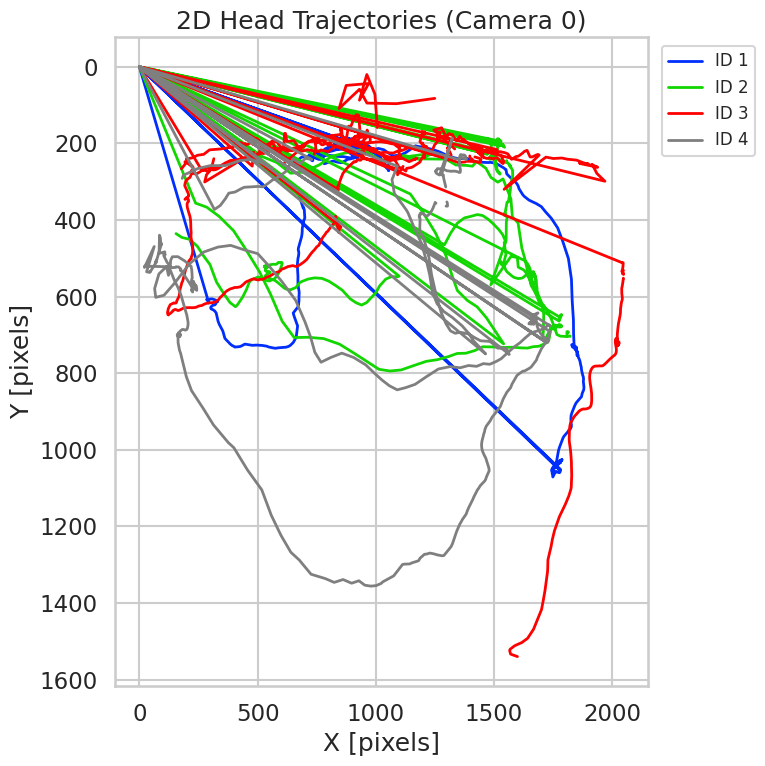

In [49]:
#head trajectory (2d)
plt.figure(figsize=(8, 8))
colors = [id_colors[i] for i in range(n_animal)]
for i in range(n_animal):
    plt.plot(head2d[i,:,0], head2d[i,:,1],
             label=animal_ids[i],
             color=colors[i],
             linewidth=2)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize=12)
plt.title("2D Head Trajectories (Camera 0)")
plt.xlabel("X [pixels]")
plt.ylabel("Y [pixels]")
plt.tight_layout()
plt.show()

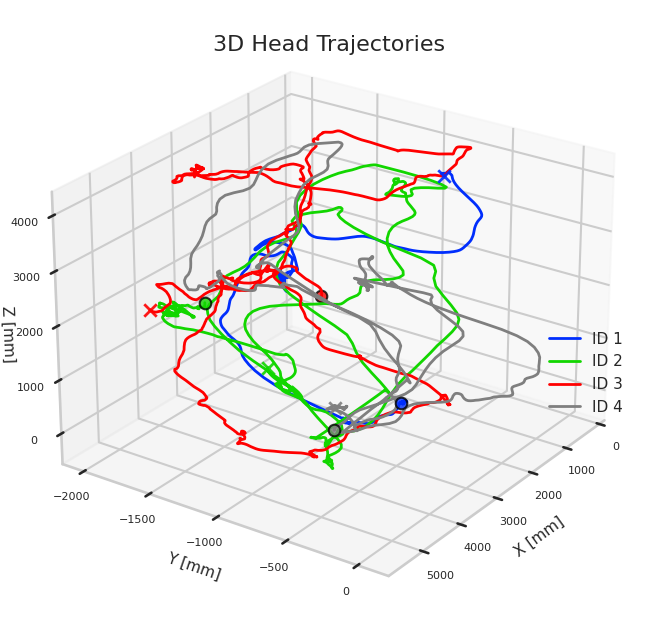

In [50]:
#head trajectory (3d)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_animal):
    color = id_colors.get(i, f"C{i}")
    ax.plot(head3d[i,:,0], head3d[i,:,1], head3d[i,:,2], 
            label=animal_ids[i], color=color, linewidth=2)
    # Start/End markers
    ax.scatter(head3d[i,0,0], head3d[i,0,1], head3d[i,0,2], 
               color=color, marker='o', s=70, edgecolor='k', alpha=0.8)
    ax.scatter(head3d[i,-1,0], head3d[i,-1,1], head3d[i,-1,2], 
               color=color, marker='x', s=80, linewidths=2, alpha=0.9)
ax.set_title("3D Head Trajectories", fontsize=16, y=1)
ax.set_xlabel("X [mm]", fontsize=11, labelpad=5)
ax.set_ylabel("Y [mm]", fontsize=11, labelpad=5)
ax.set_zlabel("Z [mm]", fontsize=11,labelpad=-1)
ax.tick_params(axis='both', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
ax.grid(alpha=0.2)
ax.view_init(elev=25, azim=35)

def get_margin(arr, frac=0.05):
    minv, maxv = np.nanmin(arr), np.nanmax(arr)
    m = (maxv - minv) * frac
    return minv - m, maxv + m

ax.set_xlim(*get_margin(head3d[:,:,0]))
ax.set_ylim(*get_margin(head3d[:,:,1]))
ax.set_zlim(*get_margin(head3d[:,:,2]))

ax.legend(loc="best", bbox_to_anchor=(1, 0.5), fontsize=11, frameon=False)

plt.show()


In [51]:
"""
scale = cage_width / image_width
      = 2200 mm / 2048 px
      = ~1.074 mm/pixel
"""

'\nscale = cage_width / image_width\n      = 2200 mm / 2048 px\n      = ~1.074 mm/pixel\n'

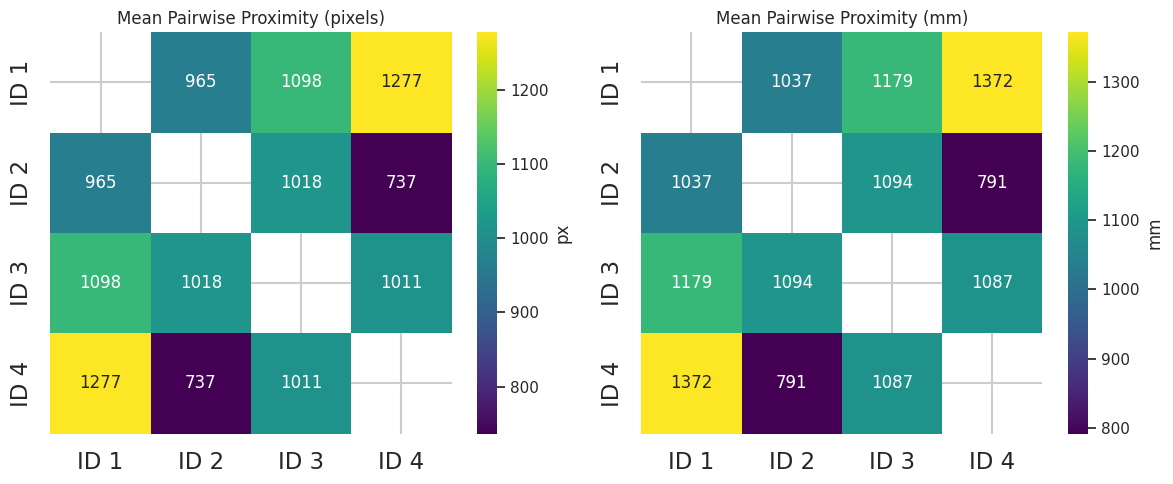

Conversion: cage_width = 2200 mm and image width = 2048 px, so 1 px = ~1.07 mm (cage size in paper).


In [52]:
#Mean Pairwise Proximity Matrix
n = n_animal
mean_dist = np.full((n, n), np.nan)
for i in range(n):
    for j in range(n):
        if i == j: continue
        h1, h2 = head2d[i,:,:2], head2d[j,:,:2]
        mask = ~np.isnan(h1[:,0]) & ~np.isnan(h2[:,0])
        if np.sum(mask) < 5:
            continue
        dists = np.linalg.norm(h1[mask] - h2[mask], axis=1)
        mean_dist[i,j] = np.nanmean(dists)

cage_width_mm = 2200
img_width_px  = 2048
scale_mm_per_px = cage_width_mm / img_width_px

mean_dist_mm = mean_dist * scale_mm_per_px

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.set_context("notebook")
sns.set_style("white")

#pixel
sns.heatmap(mean_dist, annot=True, fmt=".0f", cmap="viridis",
            xticklabels=animal_ids, yticklabels=animal_ids,
            cbar_kws={"label": "px"}, ax=axs[0])
axs[0].set_title("Mean Pairwise Proximity (pixels)")

#mm
sns.heatmap(mean_dist_mm, annot=True, fmt=".0f", cmap="viridis",
            xticklabels=animal_ids, yticklabels=animal_ids,
            cbar_kws={"label": "mm"}, ax=axs[1])
axs[1].set_title("Mean Pairwise Proximity (mm)")

plt.tight_layout()
plt.show()

print(f"Conversion: cage_width = {cage_width_mm} mm and image width = {img_width_px} px, so 1 px = ~{scale_mm_per_px:.2f} mm (cage size in paper).")

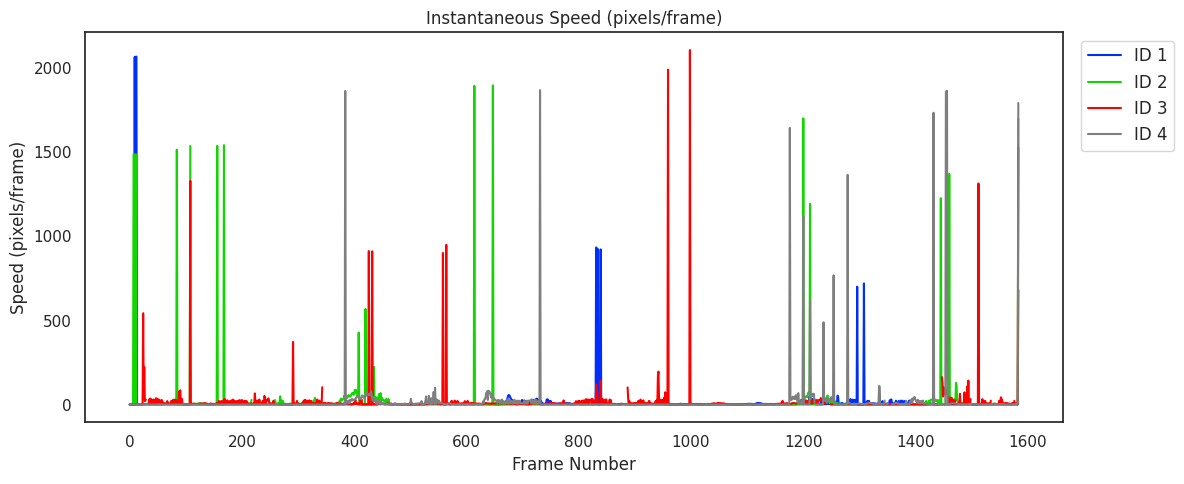

In [53]:
#Instantaneous Speed (per frame)
FPS = 24
plt.figure(figsize=(12,5))
for i in range(n_animal):
    h = head2d[i]
    speed = np.sqrt(np.sum(np.diff(h, axis=0, prepend=np.nan)[1:]**2, axis=1))
    speed_mm_per_s = speed * scale_mm_per_px * FPS
    plt.plot(frame_nums[1:] if frame_nums is not None and len(frame_nums)==len(speed) else np.arange(len(speed)), 
             speed, label=animal_ids[i], color=id_colors[i], linewidth=1.5)
plt.title("Instantaneous Speed (pixels/frame)")
plt.xlabel("Frame" if frame_nums is None else "Frame Number")
plt.ylabel("Speed (pixels/frame)")
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize=12)
plt.tight_layout()
plt.show()

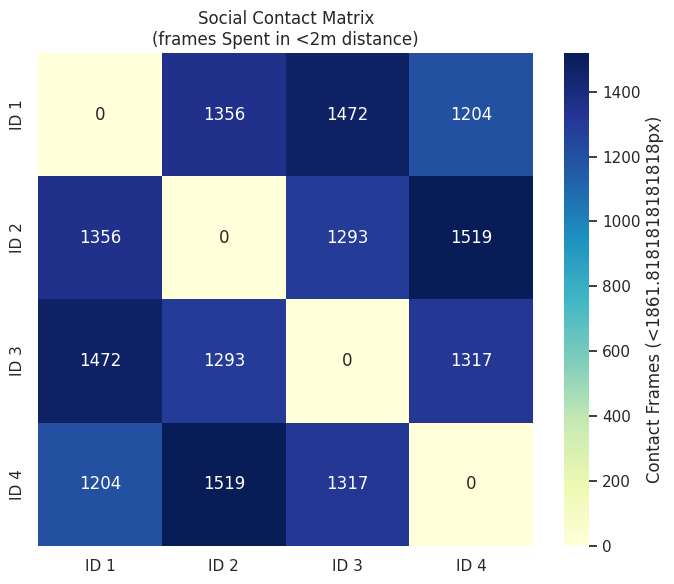

In [54]:
#interactions
CONTACT_THRESHOLD = (2000 / scale_mm_per_px) # = ~1862 px
if head2d is not None:
    n = head2d.shape[0]
    contact_counts = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i+1, n):
            h1, h2 = head2d[i], head2d[j]
            mask = ~np.isnan(h1[:,0]) & ~np.isnan(h2[:,0])
            dists = np.linalg.norm(h1[mask] - h2[mask], axis=1)
            n_contacts = np.sum(dists < CONTACT_THRESHOLD)
            contact_counts[i, j] = n_contacts
            contact_counts[j, i] = n_contacts
    plt.figure(figsize=(7, 6))
    sns.heatmap(contact_counts, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=animal_ids, yticklabels=animal_ids,
                cbar_kws={"label": f"Contact Frames (<{CONTACT_THRESHOLD}px)"})
    plt.title("Social Contact Matrix\n(frames Spent in <2m distance)")
    plt.tight_layout()
    plt.show()


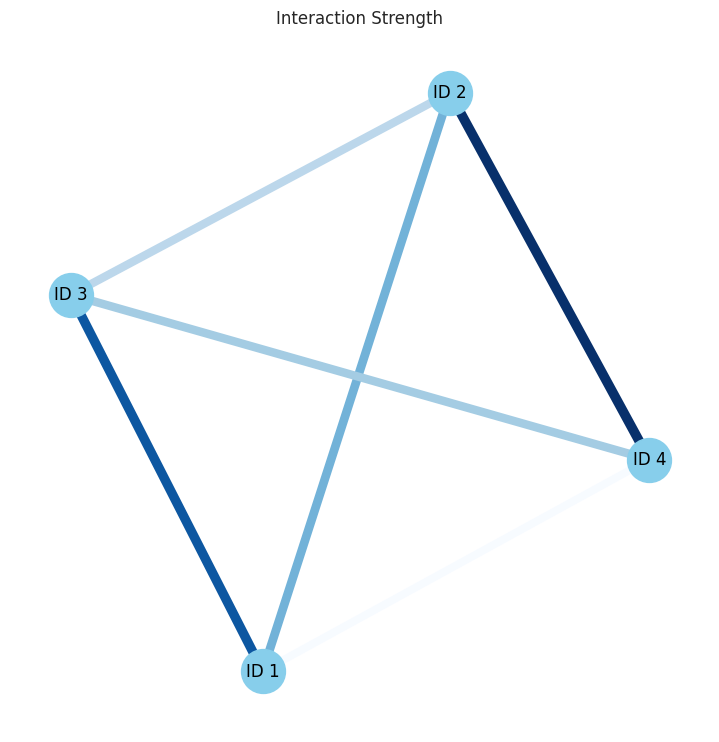

In [55]:
#interaction strength
import networkx as nx
if head2d is not None:
    G = nx.Graph()
    for i in range(n):
        G.add_node(animal_ids[i])
    for i in range(n):
        for j in range(i+1, n):
            if contact_counts[i, j] > 0:
                G.add_edge(animal_ids[i], animal_ids[j], weight=contact_counts[i, j])
    plt.figure(figsize=(7,7))
    pos = nx.spring_layout(G, seed=42, k=0.7)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color=weights,
            edge_cmap=plt.cm.Blues, width=[w/np.max(weights)*7 for w in weights])
    plt.title("Interaction Strength")
    plt.show()


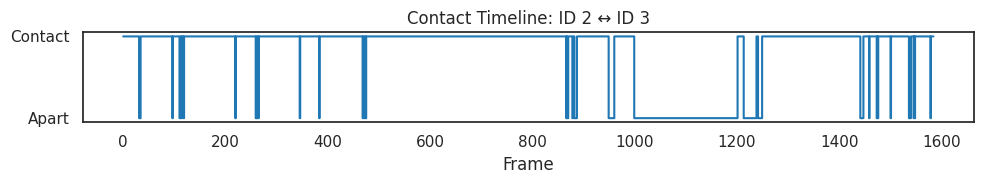

In [56]:
#contact timeline for one pair ---
PAIR = (1, 2)  # Change to any animal indices
if head2d is not None:
    h1, h2 = head2d[PAIR[0]], head2d[PAIR[1]]
    mask = ~np.isnan(h1[:,0]) & ~np.isnan(h2[:,0])
    dists = np.full(len(h1), np.nan)
    dists[mask] = np.linalg.norm(h1[mask] - h2[mask], axis=1)
    contact = dists < CONTACT_THRESHOLD
    plt.figure(figsize=(10,2))
    plt.plot(contact.astype(int), drawstyle='steps-post')
    plt.title(f"Contact Timeline: {animal_ids[PAIR[0]]} ↔ {animal_ids[PAIR[1]]}")
    plt.yticks([0,1], ["Apart", "Contact"])
    plt.xlabel("Frame")
    plt.tight_layout()
    plt.show()


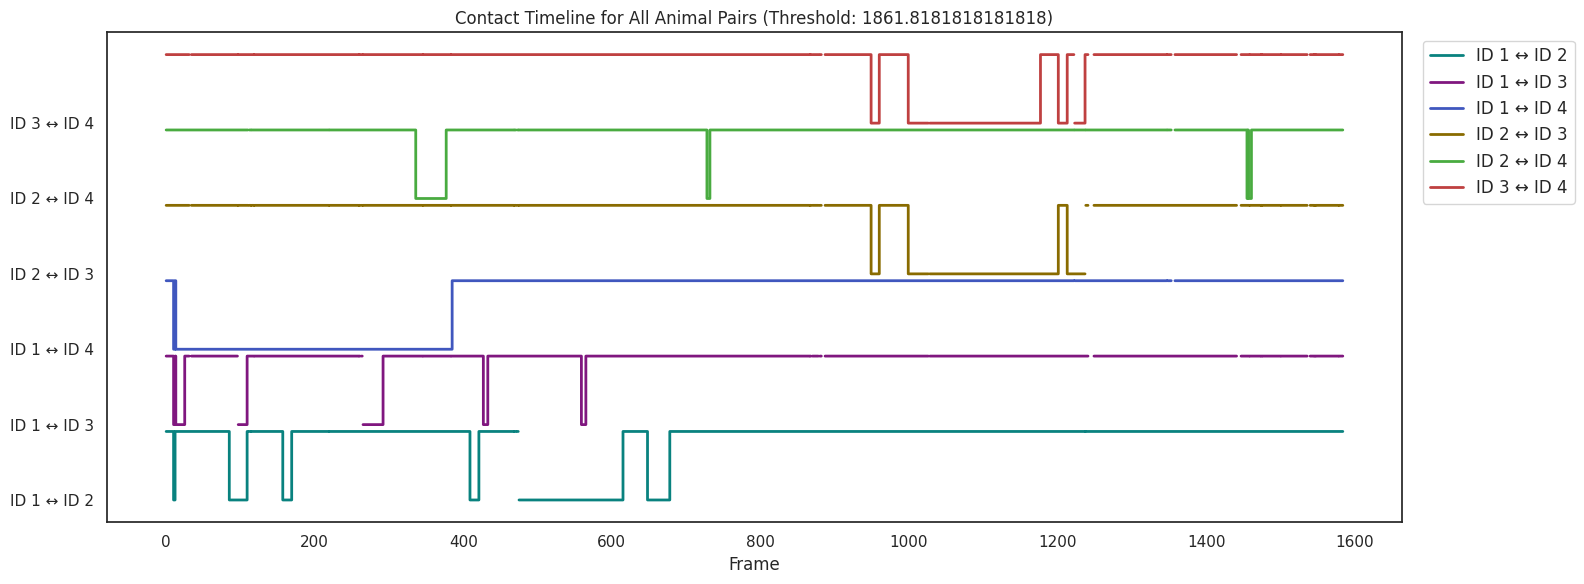

In [57]:
# Set contact threshold (in px or meters, as appropriate)

if head2d is not None:
    n = head2d.shape[0]
    pairs = [(i, j) for i in range(n) for j in range(i+1, n)]
    colors = [blend_colors(id_colors[i], id_colors[j], t=0.5) 
          for (i, j) in pairs]
    plt.figure(figsize=(16, 6))
    for idx, (i, j) in enumerate(pairs):
        h1, h2 = head2d[i], head2d[j]
        mask = ~np.isnan(h1[:,0]) & ~np.isnan(h2[:,0])
        dists = np.full(len(h1), np.nan)
        dists[mask] = np.linalg.norm(h1[mask] - h2[mask], axis=1)
        contact = np.full_like(dists, np.nan)
        contact[mask] = (dists[mask] < CONTACT_THRESHOLD).astype(int)
        # Offset each line by its index for clear stacking
        plt.plot(contact + idx*1.1, color=colors[idx], lw=2, 
                 drawstyle='steps-post', label=f"{animal_ids[i]} ↔ {animal_ids[j]}")
    plt.yticks(
        [i*1.1 for i in range(len(pairs))], 
        [f"{animal_ids[i]} ↔ {animal_ids[j]}" for i, j in pairs]
    )
    plt.xlabel("Frame")
    plt.title(f"Contact Timeline for All Animal Pairs (Threshold: {CONTACT_THRESHOLD})")
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=12)
    plt.tight_layout()
    plt.show()
